<div class="alert alert-block alert-info">   

# BABS 502 Project  

</div>

---

## Table of Contents
[Project description](#Description)  
[Part A: Time plot, trying transformations/adjustments, creating training and test set](#PartA)  
[Part B](#PartB)  
[Introduction & Approach](#Introduction)  
[Exploratory Data Analysis](#EDA1)  
[Potential causes of patterns](#Causes)   
[Exponential Smoothing Model](#ETS)  
[ARIMA model](#ARIMA)  
[Comparison of models](#Compare)  
[Forecasts](#Forecast)  
[Discussion](#Discussion)  
[Explanatory model](#Explanatory)


[Appendix A: ETS Models](#AppendixA)  
[Appendix B: ARIMA Models](#AppendixB)

---

<div class="alert alert-block alert-info">   
<a id="Description"></a>

# Project description

**Objective**  

The main goal of this project is to develop a model to forecast monthly energy use for the Vancouver International Airport (YVR).  

<br>

**Introduction**  

Budget planning at YVR requires forecasting the cost of energy to operate the airport. An accurate forecast could help the YVR representatives negotiate more favourable contracts with energy suppliers.

<br>

**Data Available**  

Data was taken from 14 years of records from the YVR database. This data set includes information on date, energy use, temperature, terminal area, and number of passengers. Data have been aggregated by month into 168 records (14 years with 12 months each).  

<br>


| # | Variable | Definition |  
| :- | :- | :- |  
| 1 | month | Month and year, e.g.: Nov-98 |
| 2 | energy | Energy use measured in thousands of kilowatt hours (kWh) |
| 3 | mean.temp | Mean monthly temperature outside (degrees Celsius) |
| 4 | total.area | Total area of all terminals (sq. m.) |
| 5 | total.passengers | Total number of passengers in thousands |
| 6 | domestic.passengers | Total number of domestic passengers (traveling within Canada) in thousands |
| 7 | US.passengers | Total number of passengers traveling between Canada and the US in thousands |
| 8 | international.passengers | Total number of passengers traveling between YVR and countries other than Canada/US |



---

<div class="alert alert-block alert-info">   

# Part A

In [1]:
library(dplyr)
library(ggplot2)
library(forecast)
library(seasonal)
library(xts)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last





### Import the data

In [2]:
df = read.csv("Energy use at YVR.csv", header = TRUE)
df %>% head()


,month,energy,mean.temp,total.area,total.passengers,domestic.passengers,US.passengers,international.passengers
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,Jan-97,5958,3.9,202966,1068.36,573.84,263.13,231.38
2,Feb-97,5859,5.0,202966,1040.30,570.36,267.39,202.56
3,Mar-97,5230,6.3,202966,1195.47,632.68,319.09,243.71
4,Apr-97,5654,9.1,202966,1086.42,599.11,265.37,221.94
5,May-97,5618,14.0,202966,1244.52,673.70,307.55,263.27
6,Jun-97,5963,15.6,202966,1352.89,729.84,333.89,289.16



### Time plot

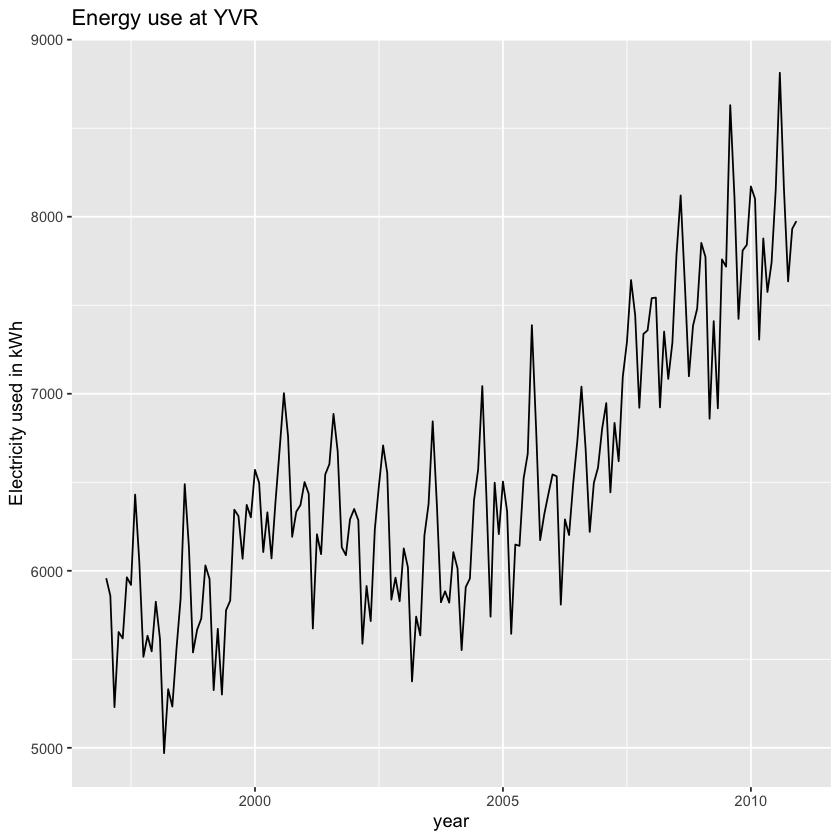

In [3]:
yvr = ts(df[, 2], start = c(1997, 1), frequency = 12)
yvr %>% autoplot(main = "Energy use at YVR", xlab = "year", ylab = "Electricity used in kWh")


### Box-Cox transformation

[1] 0.6931483

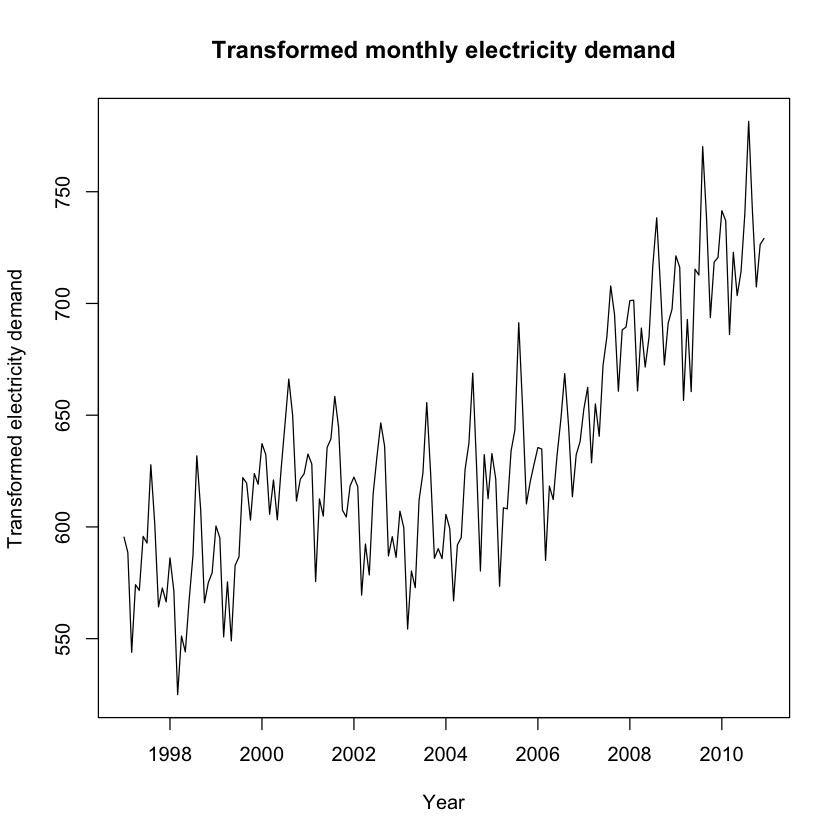

In [4]:
lambda <- BoxCox.lambda(yvr) 
lambda
plot(BoxCox(yvr,lambda), ylab="Transformed electricity demand",
     xlab="Year", main="Transformed monthly electricity demand")


### Calendar adjustment for number of days in each month

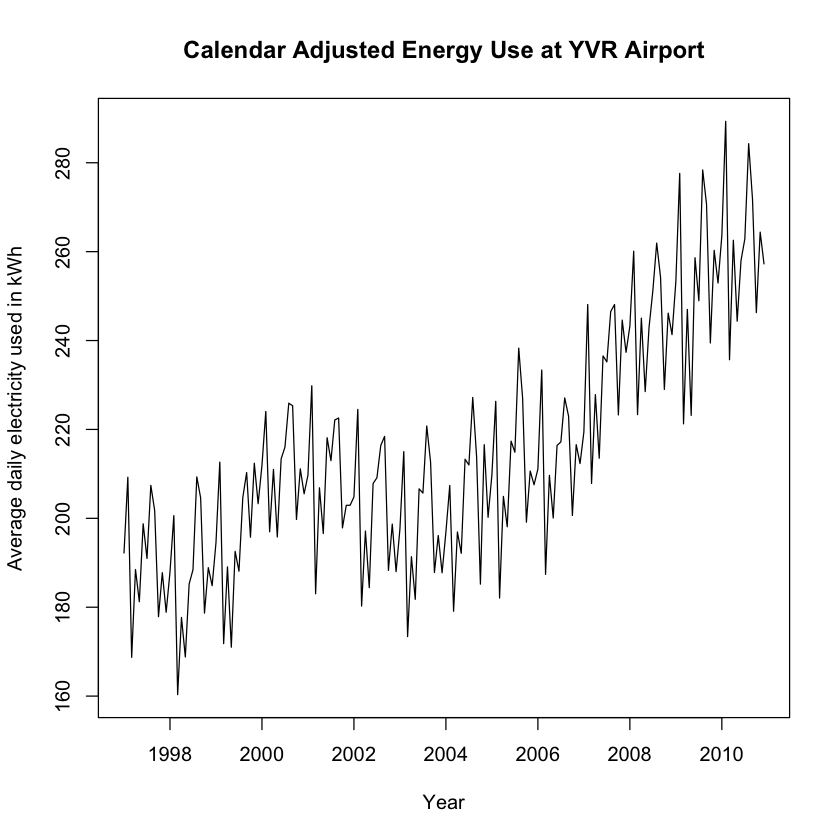

In [5]:
caladj = yvr/monthdays(yvr)
plot(caladj, main = "Calendar Adjusted Energy Use at YVR Airport", xlab = "Year", ylab = "Average daily electricity used in kWh")

### Divide the data into the training set and the test set

In [6]:
yvr.train = window(yvr, end = c(2007, 12))
yvr.test = window(yvr, start = 2008)

yvr.train
yvr.test

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1997,5958,5859,5230,5654,5618,5963,5920,6430,6053,5514,5633,5545
1998,5825,5617,4970,5331,5233,5557,5841,6489,6138,5539,5667,5730
1999,6030,5954,5326,5672,5301,5777,5831,6345,6309,6068,6372,6302
2000,6570,6497,6106,6330,6070,6401,6697,7003,6760,6192,6334,6371
2001,6501,6435,5674,6206,6094,6544,6602,6886,6677,6133,6088,6291
2002,6349,6286,5588,5914,5716,6235,6483,6708,6553,5837,5961,5828
2003,6126,6020,5375,5741,5635,6199,6376,6844,6379,5822,5884,5820
2004,6105,6014,5552,5908,5956,6399,6572,7043,6418,5741,6497,6207
2005,6504,6337,5644,6148,6141,6521,6661,7387,6815,6173,6319,6434
2006,6544,6534,5809,6290,6202,6492,6733,7040,6690,6220,6497,6582


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,7540,7543,6923,7351,7084,7288,7788,8120,7628,7099,7385,7481
2009,7852,7773,6859,7410,6918,7759,7718,8630,8121,7423,7809,7841
2010,8171,8101,7306,7877,7575,7740,8149,8813,8154,7635,7932,7975


----

<div class="alert alert-block alert-info">   

# Part B
<a id="PartB"></a>  

</div>

The objective of this project is to build a model to accurately predict the monthly energy usage at Vancouver International Airport (YVR). The purpose of the analysis is to provide YVR with more accurate budget planning information that will allow the representatives to negotiate more favorable contracts with energy suppliers. The airport's energy consumption is a significant cost factor, and having accurate predictions of usage will be an invaluable tool for making informed decisions about energy procurement.

The background of the project is that YVR is one of the busiest airports in Canada, serving over 25 million passengers annually. This high volume of activity requires a significant amount of energy to keep the airport operating, which makes accurate budgeting and cost management essential. In order to ensure that YVR is able to negotiate favorable energy contracts, it is important to have accurate predictions of energy usage.

The approach taken in the analysis is to use models in R to analyze historical energy usage data and make predictions about future energy consumption. The model will be trained on data from the past 14 years to capture patterns in energy usage and identify important factors that impact consumption. The predictions generated by the model will be used to create an accurate budget for YVR and inform negotiations with energy suppliers. The goal is to develop a model that is both accurate and robust, so that YVR can rely on its predictions to make informed decisions about energy procurement.

<div class="alert alert-block alert-warning">
<a id="Causes"></a>

# Exploratory Analysis


----

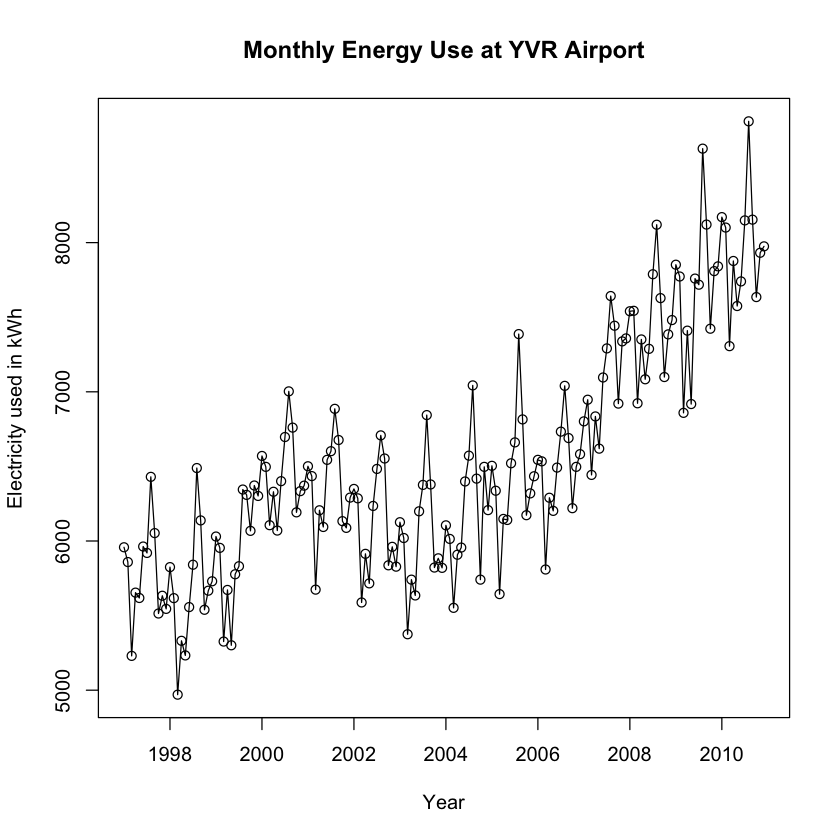

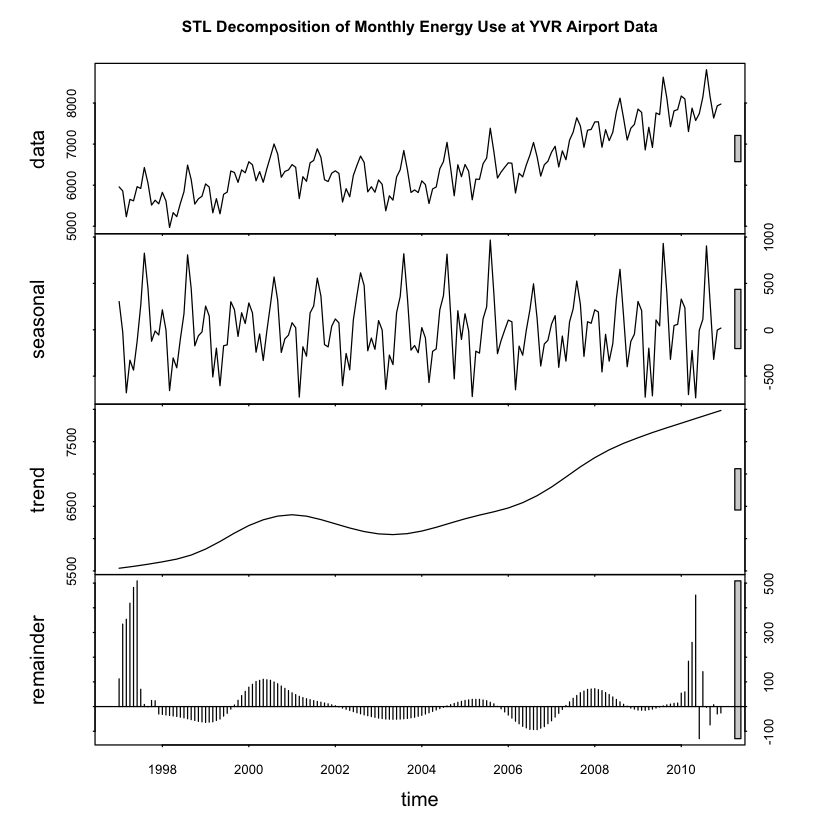

In [7]:
plot(yvr, ylab="Electricity used in kWh", xlab="Year", main="Monthly Energy Use at YVR Airport", type="o")

stl = stl(yvr, s.window = 3, robust = TRUE)

plot(stl, main = "STL Decomposition of Monthly Energy Use at YVR Airport Data")

Seasonality: The amount of seasonality varied quite significantly through the years. In some years the seasonality was stronger than others. For instance, the seasonality in year 2000 was very minor, and the seasonality in recent years are much more significant. It doesn't look like the seasonality was increasing or decreasing constantly, but rather affected by some other variables. 
Trend/cycle: The overall trend is going upwards. It increased through the first few years until 2000, and then started to decrease till 2004. Ever since it was increasing quite smoothly at a rate that is similar to pre-2000. 
Unusual features: There was significant remainder in the first few months, as well as in some months towards the end of the data. 

<div class="alert alert-block alert-warning">
<a id="Causes"></a>

# Potential causes 

In [8]:
x <- as.Date(paste("01-", df[0:48,]$month, sep = ""), format = "%d-%b-%y")
y <- as.Date(paste("01-", df[49:168,]$month, sep = ""), format = "%d-%y-%b") # convert month column to from char to date

In [9]:
df$month = c(x,y)

In [10]:
df %>% head()

,month,energy,mean.temp,total.area,total.passengers,domestic.passengers,US.passengers,international.passengers
,<date>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1997-01-01,5958,3.9,202966,1068.36,573.84,263.13,231.38
2,1997-02-01,5859,5.0,202966,1040.30,570.36,267.39,202.56
3,1997-03-01,5230,6.3,202966,1195.47,632.68,319.09,243.71
4,1997-04-01,5654,9.1,202966,1086.42,599.11,265.37,221.94
5,1997-05-01,5618,14.0,202966,1244.52,673.70,307.55,263.27
6,1997-06-01,5963,15.6,202966,1352.89,729.84,333.89,289.16


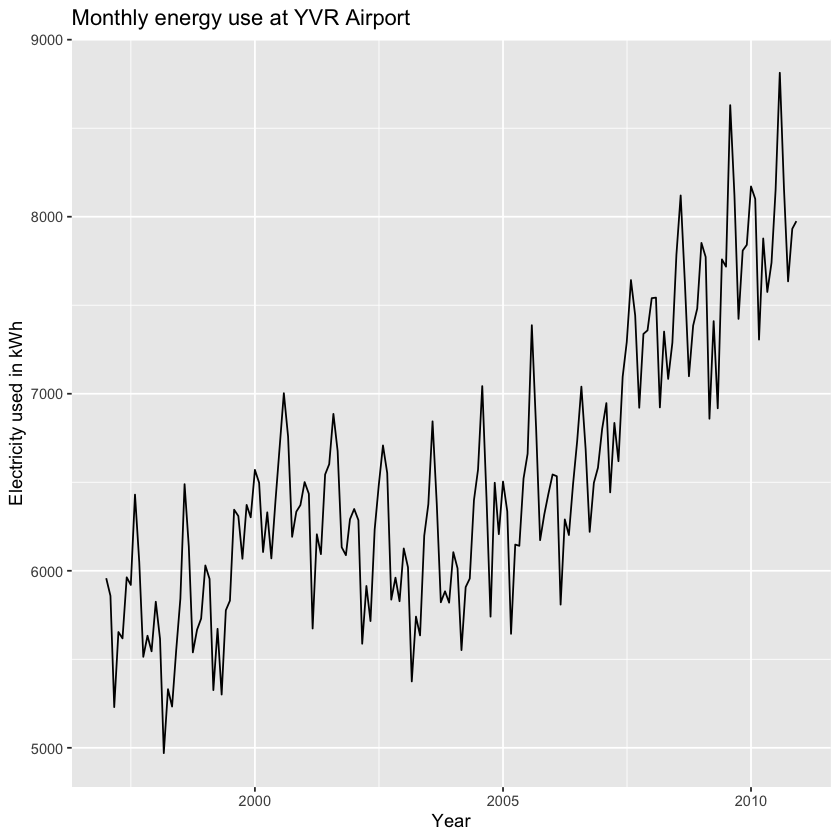

In [11]:
ggplot(df, aes(x = month)) + 
geom_line(aes(y = energy)) + 
ggtitle('Monthly energy use at YVR Airport') +
xlab('Year') +
ylab('Electricity used in kWh')

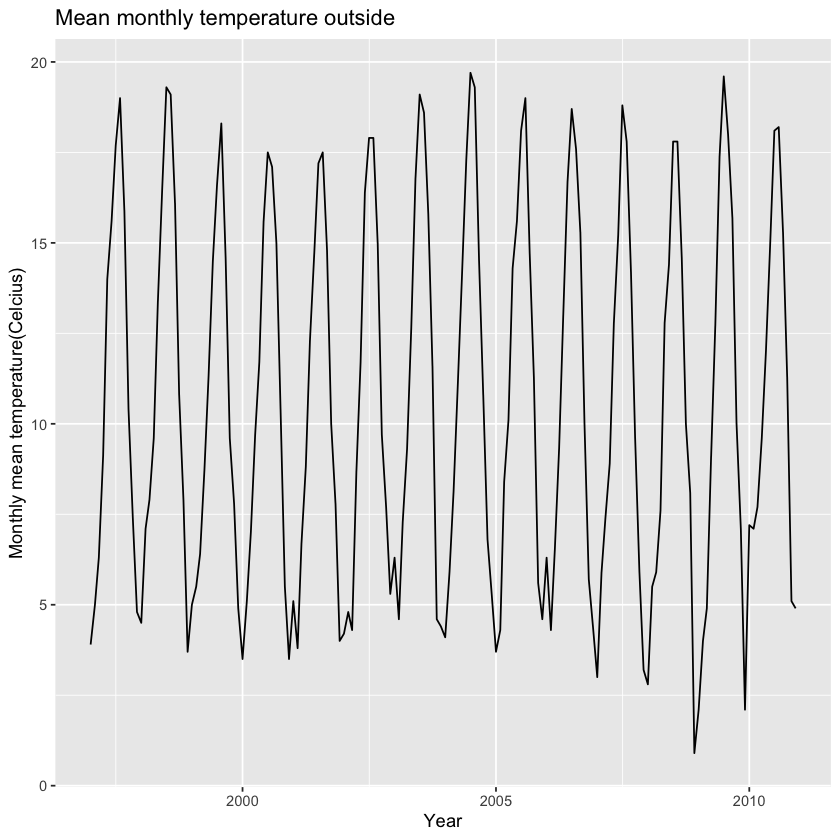

In [12]:
ggplot(df, aes(x = month)) + 
geom_line(aes(y = mean.temp)) + 
ggtitle('Mean monthly temperature outside') +
xlab('Year') + 
ylab('Monthly mean temperature(Celcius)')


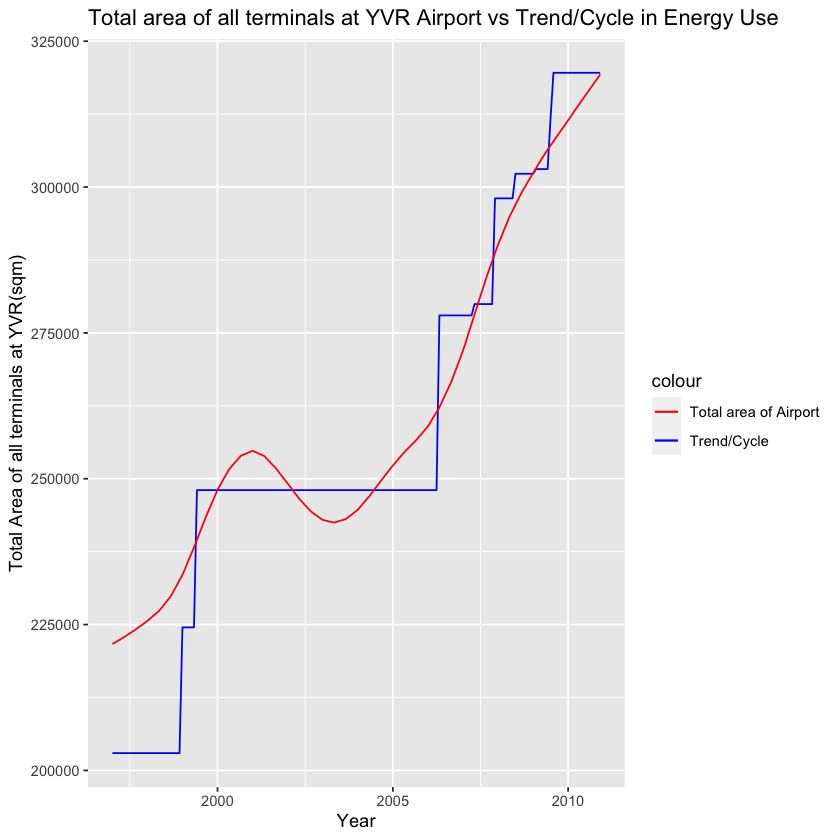

In [13]:
ggplot(df, aes(x = month)) + 
geom_line(aes(y = total.area, color = 'red')) + 
geom_line(aes(y = stl$time.series[,2]*40, color = 'blue')) + 
scale_colour_manual(values = c('red', 'blue'), labels = c("Total area of Airport", 'Trend/Cycle')) + 
ggtitle('Total area of all terminals at YVR Airport vs Trend/Cycle in Energy Use') + 
xlab('Year') +
ylab('Total Area of all terminals at YVR(sqm)')

Take a look at the correlation between the total area of the airport with the trend/cycle component of the STL decomposition

In [14]:
cor(df$total.area, stl$time.series[,2])

[1] 0.9699491

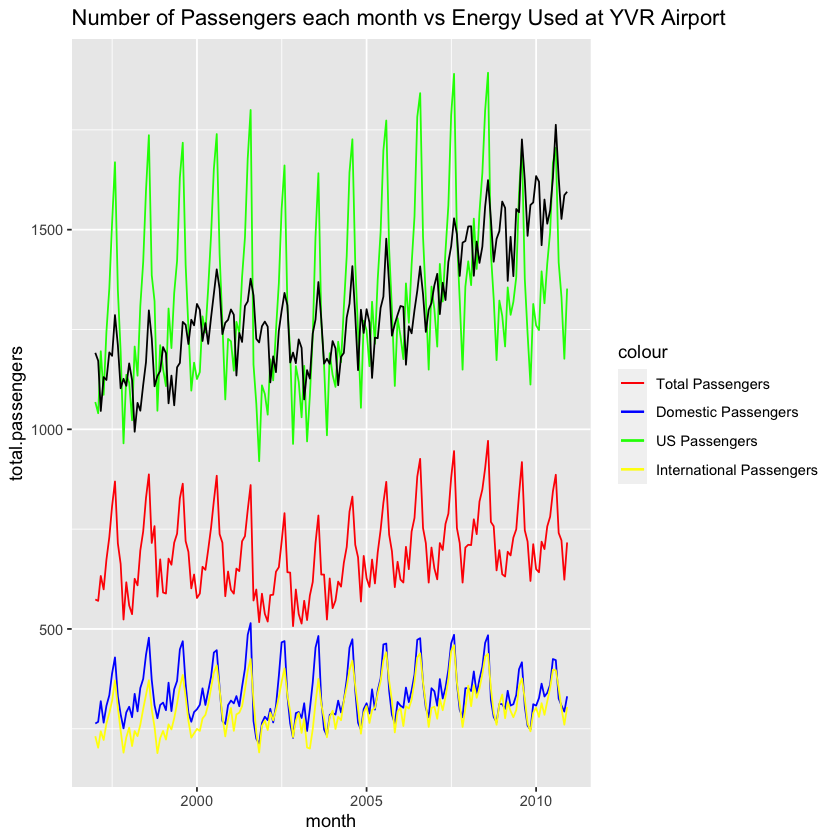

In [15]:
ggplot(df, aes(x = month)) + 
geom_line(aes(y = total.passengers, color = 'red')) +
geom_line(aes(y = domestic.passengers, color = 'blue')) +
geom_line(aes(y = US.passengers, color = 'green')) +
geom_line(aes(y = international.passengers, color = 'yellow')) + 
geom_line(aes(y = energy/5)) +
scale_colour_manual(values = c('red', 'blue', 'green','yellow', 'black'), labels = c("Total Passengers", 'Domestic Passengers', 'US Passengers', 'International Passengers', 'Energy Use')) +
labs(title = 'Number of Passengers each month vs Energy Used at YVR Airport', xlab = 'Year', ylab = 'Number of Passengers')


It looks like other factors in the data frame can help to explain the unusual features in the time series data. By plotting each of these explanatory variables acorss time, we can try to look for patterns in these plots that may explain features of the energy use plot. It seems that the variable mean.temp have a relationship with the seasonal variation of energy use. When the amount of seasonal variation in mean temperature is small within a year, the amount of seasonal variation in energy use is usually lower. For instance, the temperature variation in 2000 and 2001 are low, and the seasonal component of the energy use data is small as well for those years. However, this relationship isn't so strong as there are some exceptions. This makes sense because the variation in temperature is directly proportional to the amount of electricity ACs at the airport uses, which can be a main part of energy used.
    
Apart from this relationship, the total area of the airport does a better job at explaining the trend/cycle component of the decomposition. When we get rid of the seasonal variation in the energy use data, the trend left over is directly proportional to the total area of all terminals at YVR. Whenever there is an increase in the total area at the airport, there will always be an increase in the average amount of energy used. In fact, the correlation between the two variables is 0.97. This makes sense as well because when there's more area in the airport, there will be more ACs, screens, and lights used, so the energy used will go up. 

As to the total number of passengers, there didn't seem to be any obvious relationship between this number with the trend component. However, it seems to have the same seasonal pattern as the energy used. While the strength of the seasonal variation in number of passengers didn't correspond to that of energy used over the years, it does look like that within each year the patterns of the two match.

----

<div class="alert alert-block alert-success">
<a id="Basic"></a>

# Basic forecasting methods
</div>  

 
## Visual comparison and assessment of basic methods 

In [16]:
mean = meanf(yvr.train, h = 36)

drift = rwf(yvr.train, h = 36, drift = TRUE)

naive = naive(yvr.train, h = 36)

snaive = snaive(yvr.train, h = 36)

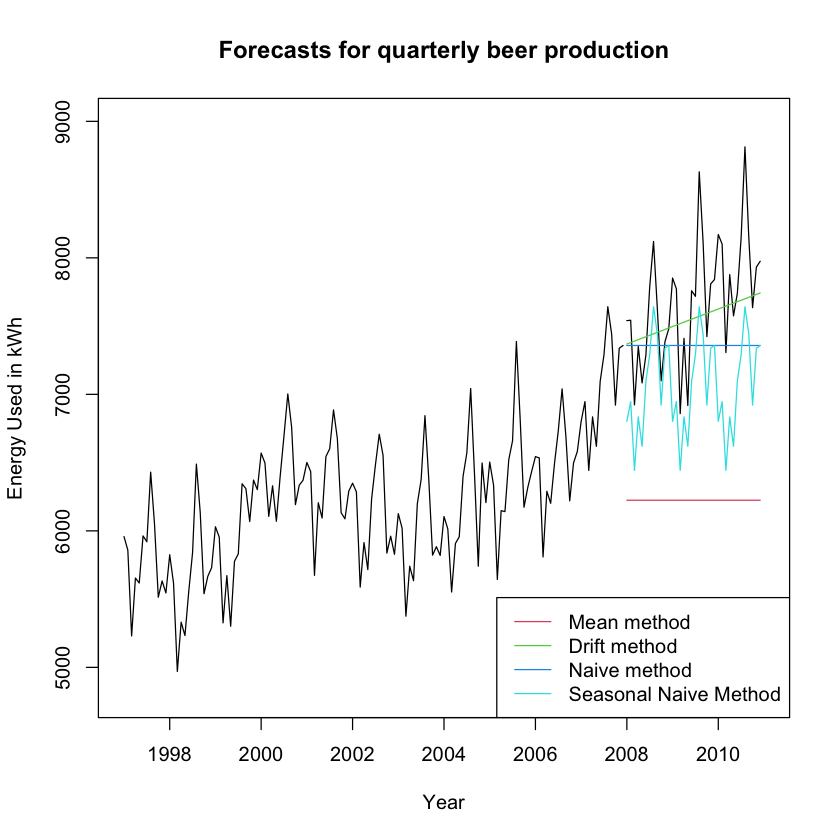

In [17]:
plot(yvr.train, main="Forecasts for quarterly beer production", ylab = "Energy Used in kWh", xlab = "Year", xlim=c(1997, 2011), ylim=c(4800, 9000))
lines(yvr.test)
lines(mean$mean,col=2) 
lines(drift$mean,col=3)
lines(naive$mean,col=4)
lines(snaive$mean, col = 5)
legend("bottomright",lty=1,col=c(2,3,4,5), legend=c("Mean method","Drift method","Naive method", "Seasonal Naive Method"))

Looking at the forecasts visually, the seasonal naive method is the best one among the four. This is because it mimics the seasonal variation in the training set, which is the most significant feature of this data. All the other methods obviously don't make sense in this case. 

## Accuracy measures 


In [18]:
method = c('Mean Method', 'Drift Method', 'Naive method', 'Seasonal Naive Method')
cbind(method, rbind(round(accuracy(mean, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(drift, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(naive, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1),
                    round(accuracy(snaive, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1)))


method,RMSE,MAE,MAPE,MASE
Mean Method,1528.5,1463.8,18.8,5.5
Drift Method,416,328.5,4.2,1.2
Naive method,550.1,443.2,5.6,1.7
Seasonal Naive Method,698.7,626.8,8,2.4


## Comparison of basic methods 

Based on the accuracy metrics, the drift method is the best method. Its MASE of 1.2 means that the mean of the absolute difference between the actual values of the test set and the forecasted values is 1.2 times of the mean of the absolute differences between the actual values and the mean of actual values. 

----

<div class="alert alert-block alert-success">
<a id="ETS"></a>

# Exponential Smoothing (ETS) model



In [19]:
yvr.ets = hw(yvr.train, seasonal = "additive", h = 36)
summary(yvr.ets)


Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 hw(y = yvr.train, h = 36, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.7846 
    beta  = 1e-04 
    gamma = 1e-04 

  Initial states:
    l = 5879.3546 
    b = 12.3652 
    s = -36.7977 -27.2016 -238.1219 321.0426 666.3048 232.4424
           58.5104 -349.8579 -192.2142 -564.3842 38.3341 91.9432

  sigma:  134.6878

     AIC     AICc      BIC 
1955.855 1961.224 2004.863 

Error measures:
                    ME     RMSE      MAE         MPE     MAPE      MASE
Training set -1.171192 126.2613 98.95847 -0.06213835 1.594299 0.3734517
                    ACF1
Training set 0.005411505

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2008       7485.996 7313.387 7658.605 7222.013 7749.979
Feb 2008       7444.636 7225.222 7664.050 7109.071 7780.200
Mar 2008       6854.252 6596.383 7112.120 6459.876 7248.627
Apr 2008       7238.806 6947.507 7530

alpha = 0.7846 
beta  = 1e-04 
gamma = 1e-04 

It makes sense to use Holt-Winters Additive Method in this case because firstly, the data has seasonality, so we should use Holt-Winters method instead of Holt method. Second, while the seasonal component has some variation through time, it doesn't seem to be increasing proportional to time, so we should use additive seasonality instead of multiplicative. As for the trend, the rate of increase of the energy use at YVR doesn't look like it's going to slow down. As a result, we should use damped = FALSE. 

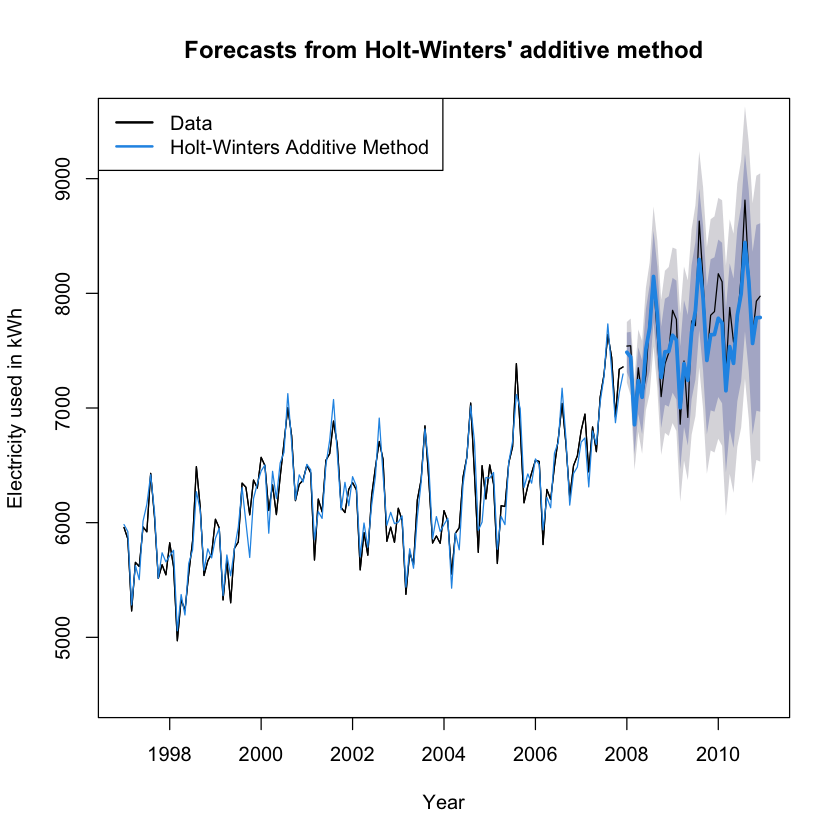

In [20]:
plot(yvr.ets, xlim = c(1997, 2011), ylim = c(4500, 9500), xlab = 'Year', ylab = 'Electricity used in kWh')
lines(yvr.train)
lines(yvr.test)
lines(fitted(yvr.ets), col = 4)
lines(yvr.ets$mean, type = 'l', lwd = 3, col = 4)
legend('topleft', c('Data', 'Holt-Winters Additive Method'), col = c(1, 4), lwd = 2)


	Ljung-Box test

data:  Residuals from Holt-Winters' additive method
Q* = 14.031, df = 8, p-value = 0.08095

Model df: 16.   Total lags used: 24



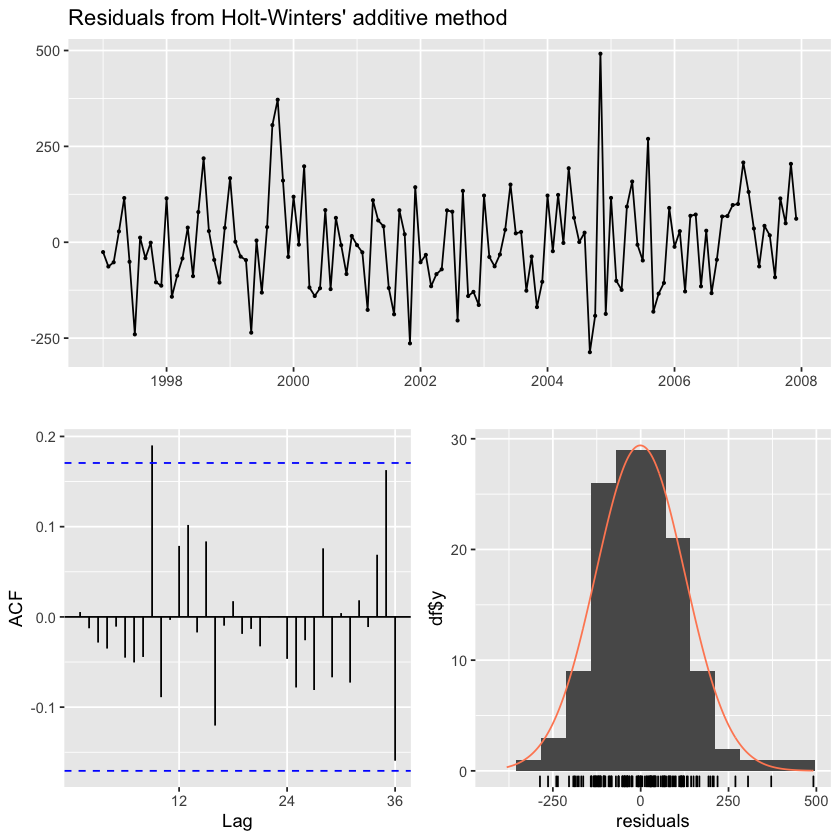

In [21]:
checkresiduals(yvr.ets)

In [22]:
accuracy(yvr.ets, yvr)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-1.171192,126.2613,98.95847,-0.06213835,1.594299,0.3734517,0.005411505,NA
Test set,78.013711,188.9986,155.89604,0.92977736,2.003689,0.5883240,0.308229307,0.3928985


In [23]:
yvr.ets1 = hw(yvr.train, seasonal = 'multiplicative', h = 36)

In [24]:
yvr.ets2 = hw(yvr.train, seasonal = 'additive', h = 36, damped = TRUE)

In [25]:
yvr.ets3 = hw(yvr.train, seasonal = 'multiplicative', h = 36, damped = TRUE)

In [26]:
method = c('Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Holt-Winters Additive damped', 'Holt-Winters Multiplicative damped')
cbind(method, rbind(round(accuracy(yvr.ets, yvr)['Training set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(yvr.ets1, yvr)['Training set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(yvr.ets2, yvr)['Training set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1),
                    round(accuracy(yvr.ets3, yvr)['Training set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1)))


method,RMSE,MAE,MAPE,MASE
Holt-Winters Additive,126.3,99,1.6,0.4
Holt-Winters Multiplicative,136.4,105.9,1.7,0.4
Holt-Winters Additive damped,126.8,99.2,1.6,0.4
Holt-Winters Multiplicative damped,127.4,99,1.6,0.4


It looks like the model fits to the training set quite well. The residuals doesn't have any pattern, and the distribution is normal. In terms of the accuracy metrics, the Holt-Winters Additive method is very close to the Holt-Winters Additive damped method and the Holt-Winters Multiplicative damped method, but just slightly better. 

## Accuracy measures 

In [27]:
accuracy(yvr.ets, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')]

RMSE        MAE       MAPE       MASE 
188.998554 155.896045   2.003689   0.588324

## Accuracy of forecasts 

In [28]:
accuracy(drift, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')]
accuracy(yvr.ets, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')]


RMSE        MAE       MAPE       MASE 
415.979013 328.482400   4.213286   1.239634

RMSE        MAE       MAPE       MASE 
188.998554 155.896045   2.003689   0.588324

Based on the plot of the forecast versus the test set, the model does a decent job at forecasting the test set period as it captures most of the seasonality pattern as well as the trend. Although it looks like the actual trend is increasing slightly more quickly than the model suggests, and the seasonality pattern in reality is a bit stronger. 

## Residual diagnostics 

In [29]:
mean(residuals(yvr.ets))
mean(abs(residuals(yvr.ets)))

[1] -1.171192

[1] 98.95847

a) A mean of residuals of -1.17 does not indicate bias as this is very close to zero considering the mean of the absolute value of residuals is close to 100. 


	Ljung-Box test

data:  Residuals from Holt-Winters' additive method
Q* = 14.031, df = 8, p-value = 0.08095

Model df: 16.   Total lags used: 24



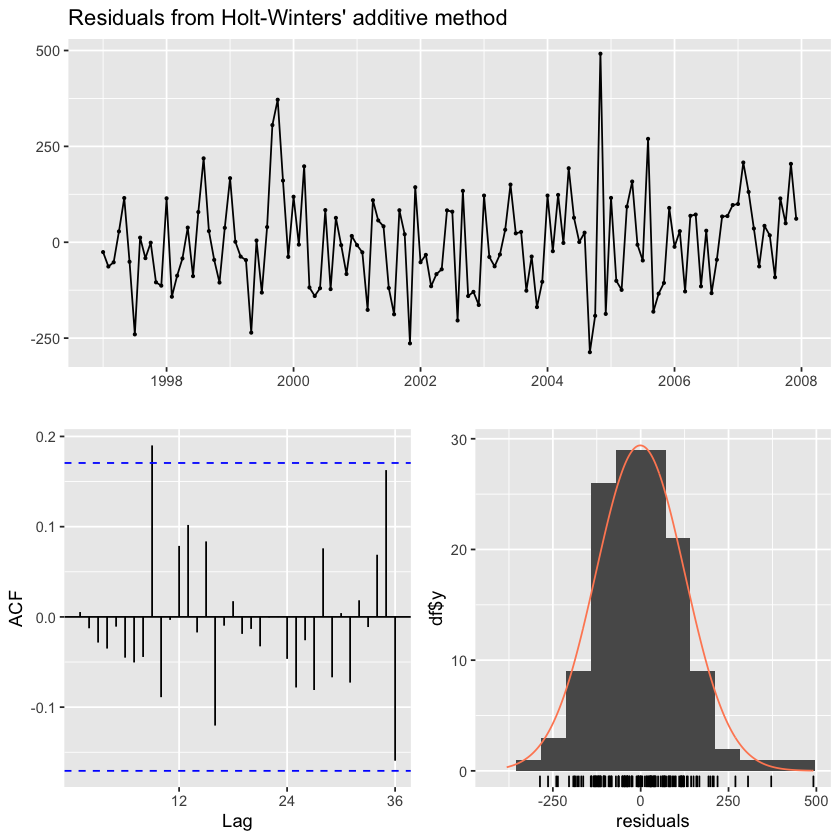

In [30]:
checkresiduals(yvr.ets)

b) The residuals seem random and doesn't have any pattern. Its shape of distribution is very close to normal distribution as well. The Acf plot shows that there's only one significant lag among the 36, which is normal considering 5% of the lags will be significant due to chance. 

c) H0: the first 24 autocorrelations are not significantly different from a white noise process
HA: the first 24 autocorrelations are significantly different from a white noise process
Number of lags used: 24
Test Statistic: Q = 14.03
p-value: 0.081
Decision: We fail to reject because p value is larger than 0.05.
Conclusion: The results from Ljung-Box test shows we can't reject the null hypothesis that the first 24 autocorrelations are not significantly different from white noise. 


----

<div class="alert alert-block alert-success">
<a id="ARIMA"></a>
    
# ARIMA model
    


In [31]:
yvr.arima = Arima(yvr.train, order = c(2, 1, 0), seasonal = c(0, 1, 1))


The model is ARIMA(2, 1, 0)x(0, 1, 1)12

In [32]:
summary(yvr.arima)

Series: yvr.train 
ARIMA(2,1,0)(0,1,1)[12] 

Coefficients:
          ar1      ar2     sma1
      -0.2016  -0.0232  -0.8970
s.e.   0.0923   0.0922   0.1868

sigma^2 = 18922:  log likelihood = -762.51
AIC=1533.02   AICc=1533.37   BIC=1544.14

Training set error measures:
                   ME     RMSE      MAE       MPE    MAPE      MASE
Training set 9.670072 128.9516 94.19108 0.1279288 1.49849 0.3554604
                     ACF1
Training set -0.006552374

AR1: -0.2016
AR2: -0.0232
SMA1: -0.8970


## Appropriateness of model 

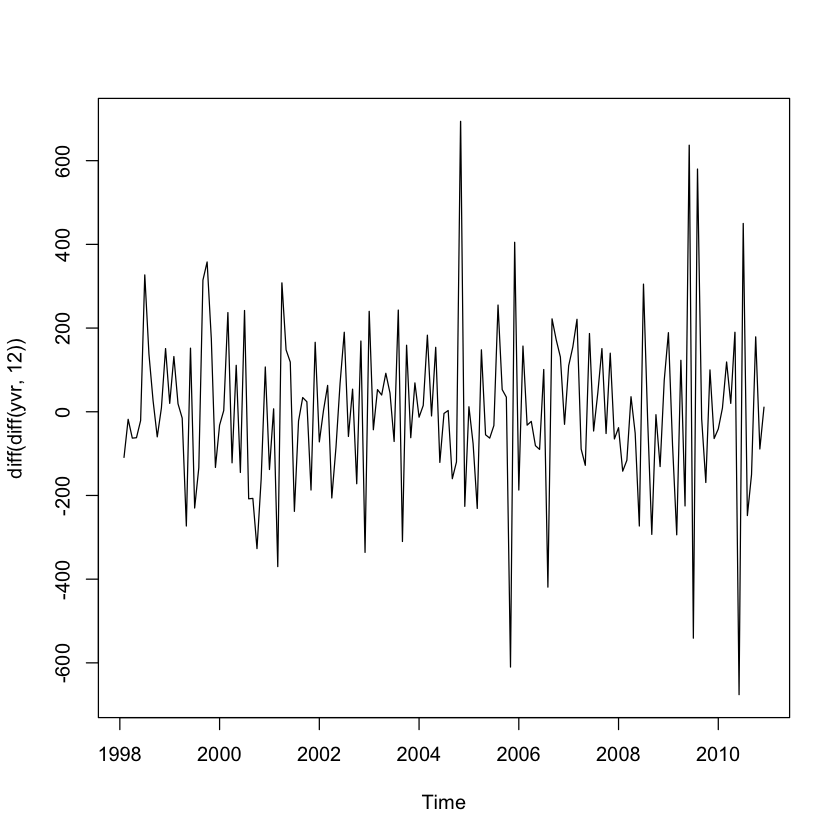

In [33]:
plot(diff(diff(yvr, 12)))


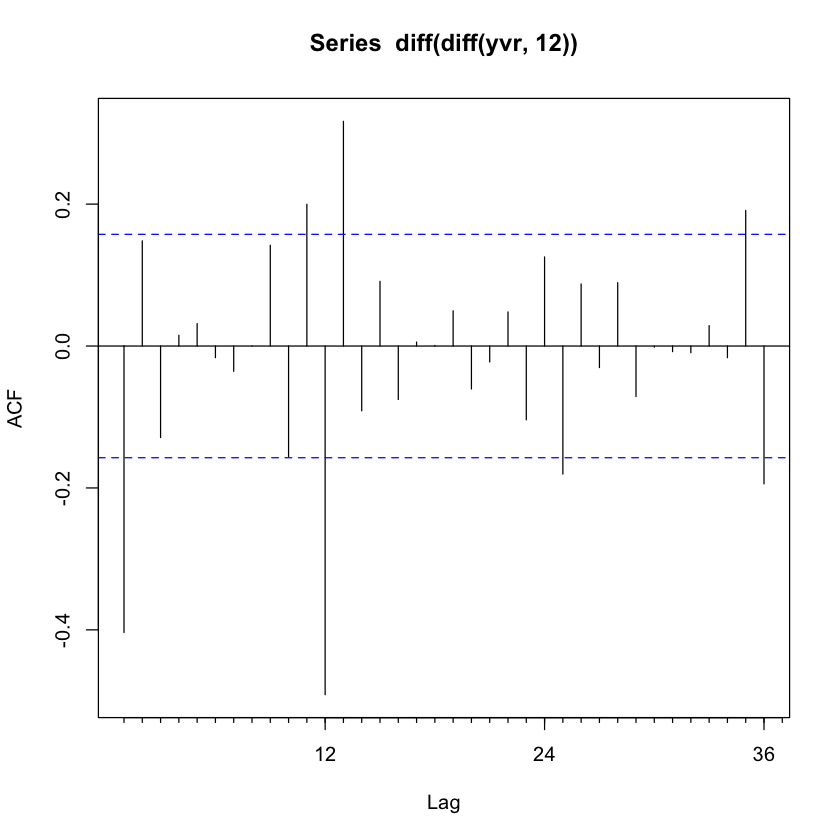

In [34]:
Acf(diff(diff(yvr, 12)), lag.max = 36)

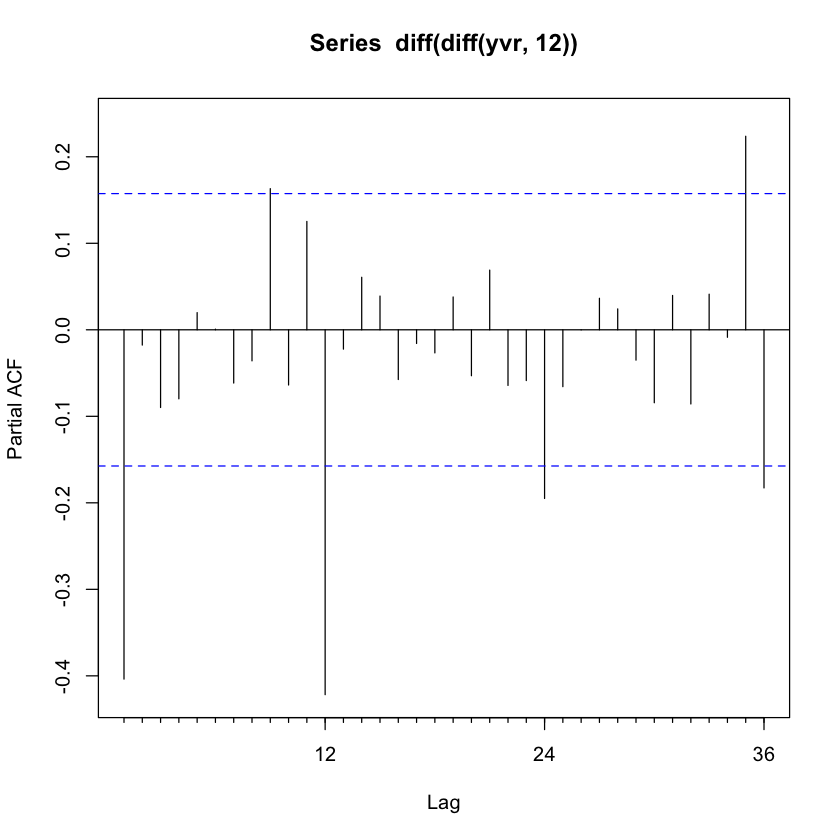

In [35]:
Pacf(diff(diff(yvr, 12)), lag.max = 36)

We need to first do seasonal differencing on the data, then first differencing. Based on the Acf and Pacf plots of differenced data, we can see that the seasonal component is simpler in the Acf plot, as the lag 24 isn't significant in the Acf plot but is significant in the Pacf plot. As a result, we should use a moving average of order 1 for the seasonal part of the model. For the non-seasonal part, the Pacf is simpler as it has three significant lags, and one of them is only slightly above the threshold. After testing the accuracy on the test set, we find that using a autoregression of order 2 works better than 3.   

## Model plot

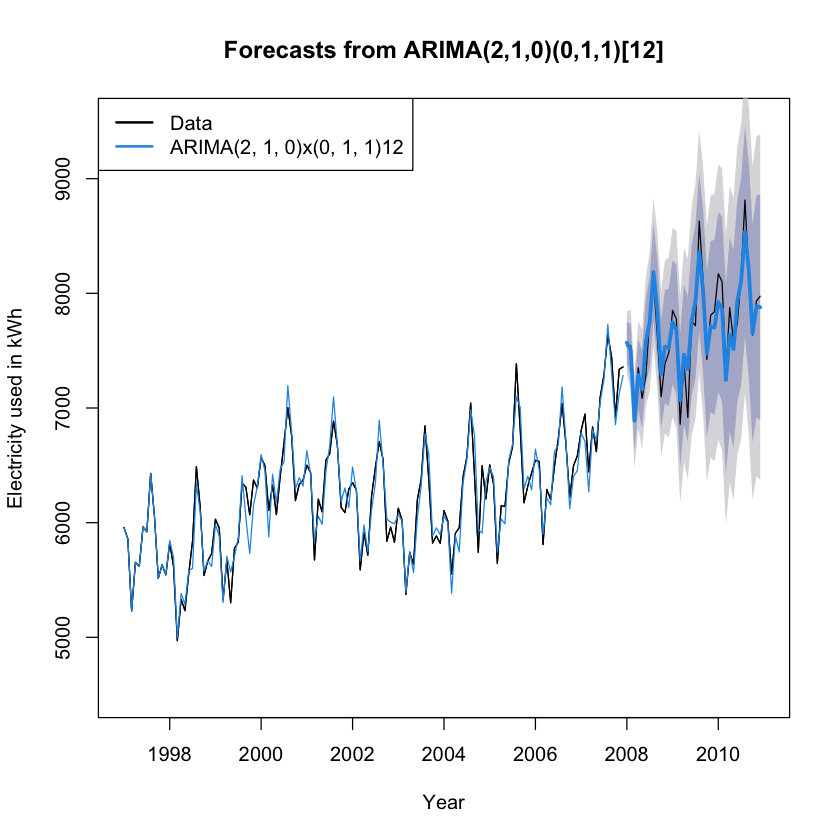

In [36]:
plot(forecast(yvr.arima, h = 36), xlim = c(1997, 2011), ylim = c(4500, 9500), xlab = 'Year', ylab = 'Electricity used in kWh')
lines(yvr.train)
lines(yvr.test)
lines(fitted(yvr.arima), col = 4)
lines(forecast(yvr.arima, h = 36)$mean, type = 'l', lwd = 3, col = 4)
legend('topleft', c('Data', 'ARIMA(2, 1, 0)x(0, 1, 1)12'), col = c(1, 4), lwd = 2)

## Goodness of fit 

In [37]:
yvr.arima = Arima(yvr.train, order = c(2, 1, 0), seasonal = c(0, 1, 1))
yvr.arima1 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 1))
yvr.arima2 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 2))
yvr.autoarima = auto.arima(yvr.train, stepwise = FALSE, approximation = FALSE)
yvr.arima3 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 1), lambda = lambda)


In [38]:
arimaforecast = forecast(yvr.arima, h = 36)
arimaforecast1 = forecast(yvr.arima1, h = 36)
arimaforecast2 = forecast(yvr.arima2, h = 36)
arimaforecast3 = forecast(yvr.autoarima, h = 36)
arimaforecast4 = forecast(yvr.arima3, h = 36)


In [39]:
method = c('(2, 1, 0), (0, 1, 1)', '(3, 1, 0), (0, 1, 1)','(3, 1, 0), (0, 1, 2)', 'Auto Arima', '(3, 1, 0), (0, 1, 1) with Box-Cox Transformation')
cbind('Training set', method, rbind(round(accuracy(fitted(yvr.arima), yvr), 1), 
                    round(accuracy(fitted(yvr.arima1), yvr), 1), 
                    round(accuracy(fitted(yvr.arima2), yvr), 1),
                    round(accuracy(fitted(yvr.autoarima), yvr), 1),
                    round(accuracy(fitted(yvr.arima3), yvr), 1)))


,,method,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,Training set,"(2, 1, 0), (0, 1, 1)",9.7,129,94.2,0.1,1.5,0,0.3
Test set,Training set,"(3, 1, 0), (0, 1, 1)",9.9,129,94.2,0.1,1.5,0,0.3
Test set,Training set,"(3, 1, 0), (0, 1, 2)",10.2,123.6,90.2,0.1,1.4,0,0.3
Test set,Training set,Auto Arima,9.9,146.2,104.9,0.1,1.7,0,0.4
Test set,Training set,"(3, 1, 0), (0, 1, 1) with Box-Cox Transformation",9.5,127.6,92.9,0.1,1.5,0,0.3


Based on the accuracy metrics on the training set, all of the methods are quite similar to each other. It looks like the model arima(3, 1, 0)(0, 1, 2) has the best accuracy on the training set. Looking at the graph, we can see that the model we selected also adheres to the training data quite closely. 

## Accuracy measures 

In [40]:
accuracy(forecast(yvr.arima, h = 36), yvr.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,9.6700723,128.9516,94.19108,0.12792876,1.498490,0.3554604,-0.006552374,NA
Test set,-0.5722897,160.5612,126.43376,-0.08776151,1.648344,0.4771385,0.231446134,0.3382627


RMSE: 160.56
MAE: 126.43
MAPE: 1.65
MASE: 0.48

## Accuracy of forecasts 

In addition to this model, we also tried arima(3, 1, 0), (0, 1, 1),arima(3, 1, 0), (0, 1, 2), Auto Arima, arima(3, 1, 0), (0, 1, 1) with Box-Cox Transformation. It turns out the model chosen has the lowest RMSE, MAPE, and MASE, and its MAE value is slightly higher than that of arima(3, 1, 0)(0, 1, 1) with box-cox transformation. By looking at both the plot and the accuracy metrics, we can see that the arima model performs much better than the basic methods. 

## Residual diagnostics 

In [41]:
fitted(yvr.arima)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1997,5954.560,5857.538,5229.575,5653.309,5617.481,5962.251,5919.399,6428.995,6052.464,5514.030,5632.914,5548.334
1998,5845.648,5696.555,4999.393,5382.493,5288.936,5583.044,5601.818,6337.576,6092.323,5577.388,5668.930,5618.053
1999,5984.079,5881.242,5303.531,5708.454,5569.467,5709.038,5870.442,6409.981,6040.345,5731.043,6153.915,6314.215
2000,6592.960,6451.956,5875.168,6422.814,6174.162,6467.433,6528.997,7196.054,6793.237,6295.779,6392.955,6318.756
2001,6627.491,6416.461,5845.846,6058.125,5984.770,6448.638,6671.016,7096.170,6679.834,6183.737,6302.757,6130.527
2002,6485.815,6277.378,5666.411,5979.857,5748.762,6113.910,6345.697,6894.529,6510.914,6032.596,6003.693,5991.230
2003,6067.589,6015.532,5391.642,5747.419,5564.260,6036.734,6320.328,6776.260,6597.830,5884.948,5955.107,5896.716
2004,6057.228,5996.808,5385.204,5886.882,5744.213,6349.975,6549.227,6986.468,6757.852,5942.288,5908.326,6358.208
2005,6480.817,6399.592,5742.347,6032.275,5989.644,6548.277,6687.540,7096.714,7004.296,6294.712,6404.770,6286.312
2006,6641.092,6461.285,5898.658,6215.299,6156.091,6620.784,6676.253,7183.316,6716.089,6121.488,6403.052,6453.839


In [42]:
mean(residuals(yvr.arima))

[1] 9.670072

In [43]:
max(residuals(yvr.arima)) - min(residuals(yvr.arima))

[1] 928.526

a) The mean of residuals is 9.67, considering the range of the residuals is over 900, we can say the mean is fairly close to 0, so there's no bias.


	Ljung-Box test

data:  Residuals from ARIMA(2,1,0)(0,1,1)[12]
Q* = 17.597, df = 21, p-value = 0.6743

Model df: 3.   Total lags used: 24



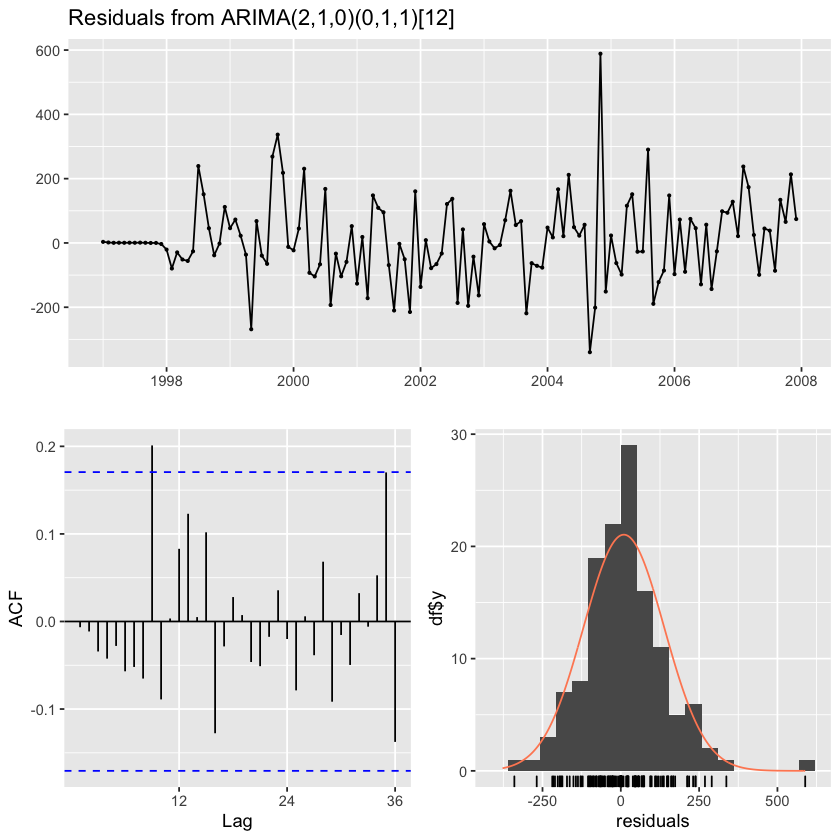

In [44]:
checkresiduals(yvr.arima)

b) It looks like the residuals quite close to equally distributed along the two sides of the x axis. There's one very large positive residual of around 600. That one observation shifted the mean of the residuals by a lot. Based on the Acf graph, there's one significant lag, which is normal since 5% of the autocorrelations are going to be significant due to chance. The distribution of the residuals isn't exactly normal, also in part due to that one very large residual. 

c) H0: the first 24 autocorrelations are not significantly different from a white noise process
HA: the first 24 autocorrelations are significantly different from a white noise process
Number of lags used: 24
Test Statistic: Q = 17.597
p-value: 0.674
Decision: We fail to reject because p value is larger than 0.05.
Conclusion: The results from Ljung-Box test shows we can't reject the null hypothesis that the first 24 autocorrelations are not significantly different from white noise. 


----

<div class="alert alert-block alert-warning">
<a id="Comparison"></a>

# Comparison of models (200 words max.) (2 marks)  



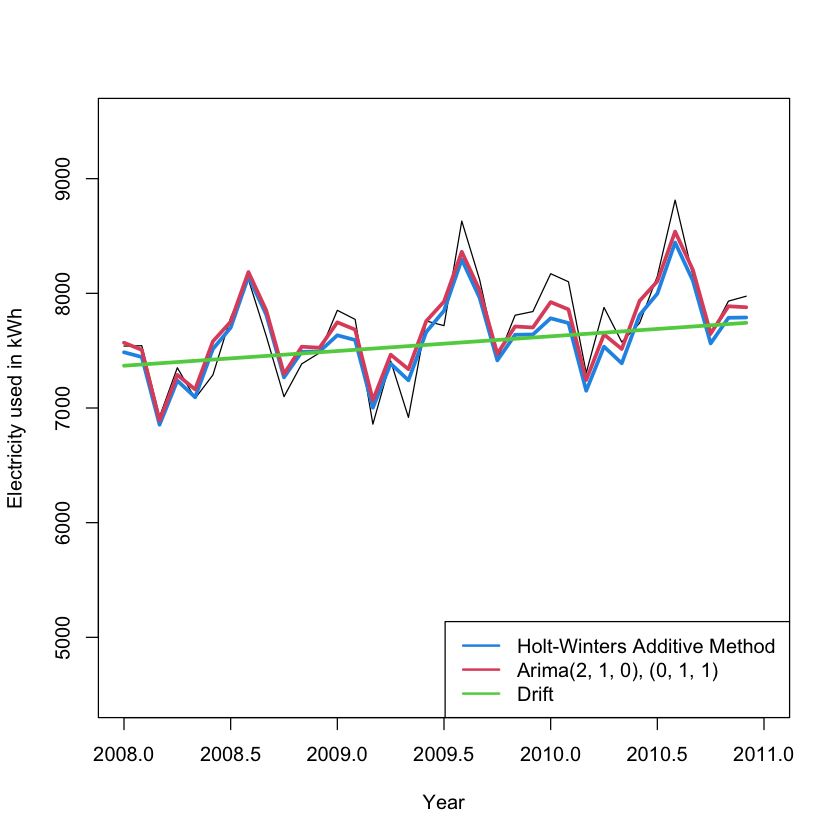

In [45]:
plot(yvr.test, xlim = c(2008, 2011), ylim = c(4500, 9500), xlab = 'Year', ylab = 'Electricity used in kWh')
lines(yvr.ets$mean, col = 4, lwd = 3)
lines(forecast(yvr.arima, h = 36)$mean, col = 2, lwd = 3)
lines(drift$mean, col = 3, lwd = 3)
legend('bottomright', c('Holt-Winters Additive Method', 'Arima(2, 1, 0), (0, 1, 1)', 'Drift'), col = c(4,2,3), lwd = 2)

<div class="alert alert-block alert-info"> 
<a id="Forecasts"></a>   
    
# Forecasts 

In [46]:
forecast = forecast(Arima(yvr, model = yvr.arima), h = 36)
forecast$mean

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2011,8214.027,8155.020,7487.691,7923.606,7725.908,8139.460,8346.367,8846.273,8442.307,7879.168,8143.567,8154.689
2012,8400.899,8341.183,7673.830,8109.766,7912.064,8325.617,8532.523,9032.430,8628.463,8065.325,8329.724,8340.846
2013,8587.056,8527.339,7859.986,8295.923,8098.221,8511.774,8718.680,9218.587,8814.620,8251.482,8515.880,8527.002


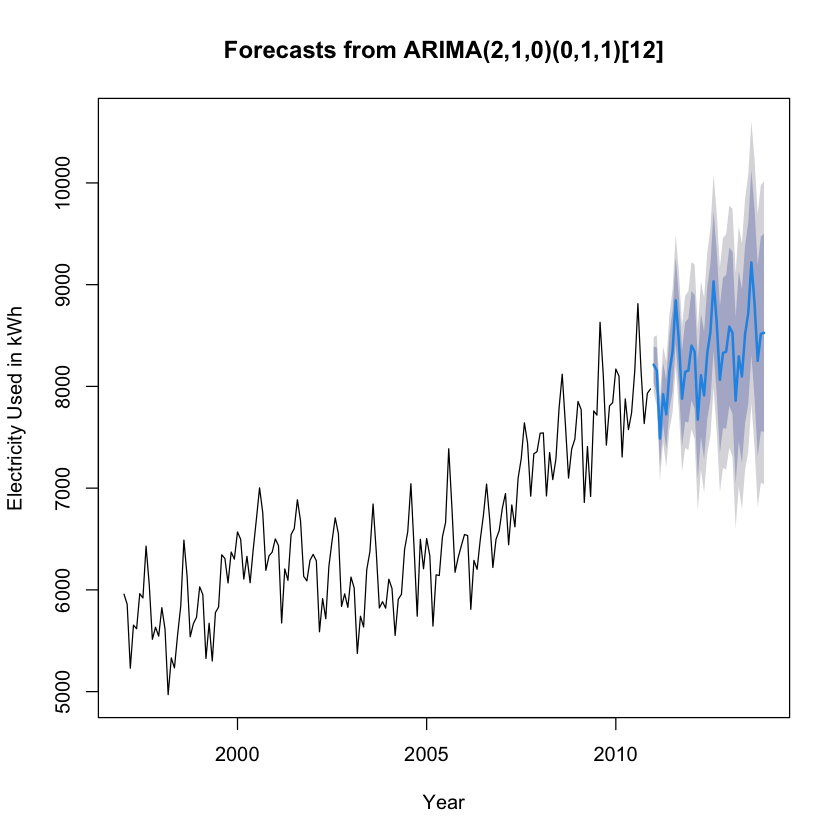

In [47]:
plot(forecast, xlab = 'Year', ylab = 'Electricity Used in kWh')

<div class="alert alert-block alert-warning">
<a id="Discussion"></a>

# Discussion 

The first limiation of our final is that throughout the data set, there has been quite a lot of variation in the magnitude of the seasonality in each year, and there doesn't seem to be any pattern to that by looking only at the time series plot. For instance, the seasonality in year 2000 is very small while the seasonality in the three recent years are strong. Our Arima model predicts the following three years with relatively constant seasonal variation, and that may not be the case in reality. As discussed before, the magnitude of seasonality of a year may be determined by the temperatures of that respective year, and we may need that data to better forecast the seasonality component. 
The second limitation is concerning the trend component. As we looked at the relationship between the trend/cycle component of the electricity usage data and the total area of the YVR airport, we can see a strong relationship between the two. In order to better forecast the trend/cycle of the data, we would need the airport's plans to expand/not expand the airport. That information should be easily available as construction takes a long time and we should be able to know approximately when these newly constructed areas are going to be in use. 
The third limitation is the outliers. Based on our residual plots and calculations, we can see the mean of the residuals of the model isn't close to 0 enough, so it's hard to tell if there's bias in the model. In fact, there was one observation with almost 600 residual. These outliers could harm the accuracy of the model. To address this problem, we could maybe do a moving average of the data before fitting the model. In addition, maybe we could have used log transformation to lower the impact of outliers. 

----

<div class="alert alert-block alert-danger">
<a id="AppendixA"></a>

# Appendix A:
# ETS models 
</div>

In [48]:
yvr.ets = hw(yvr.train, seasonal = "additive", h = 36)

In [49]:
yvr.ets1 = hw(yvr.train, seasonal = 'multiplicative', h = 36)

In [50]:
yvr.ets2 = hw(yvr.train, seasonal = 'additive', h = 36, damped = TRUE)

In [51]:
yvr.ets3 = hw(yvr.train, seasonal = 'multiplicative', h = 36, damped = TRUE)

In [52]:
method = c('Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Holt-Winters Additive damped', 'Holt-Winters Multiplicative damped')
cbind(method, rbind(round(accuracy(yvr.ets, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(yvr.ets1, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
                    round(accuracy(yvr.ets2, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1),
                    round(accuracy(yvr.ets3, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1)))

method,RMSE,MAE,MAPE,MASE
Holt-Winters Additive,189,155.9,2,0.6
Holt-Winters Multiplicative,243.6,203.9,2.6,0.8
Holt-Winters Additive damped,381.2,312.7,4,1.2
Holt-Winters Multiplicative damped,279.9,233.9,3,0.9


---

<div class="alert alert-block alert-danger">
<a id="AppendixB"></a>

# Appendix B:
# ARIMA Models 
</div>

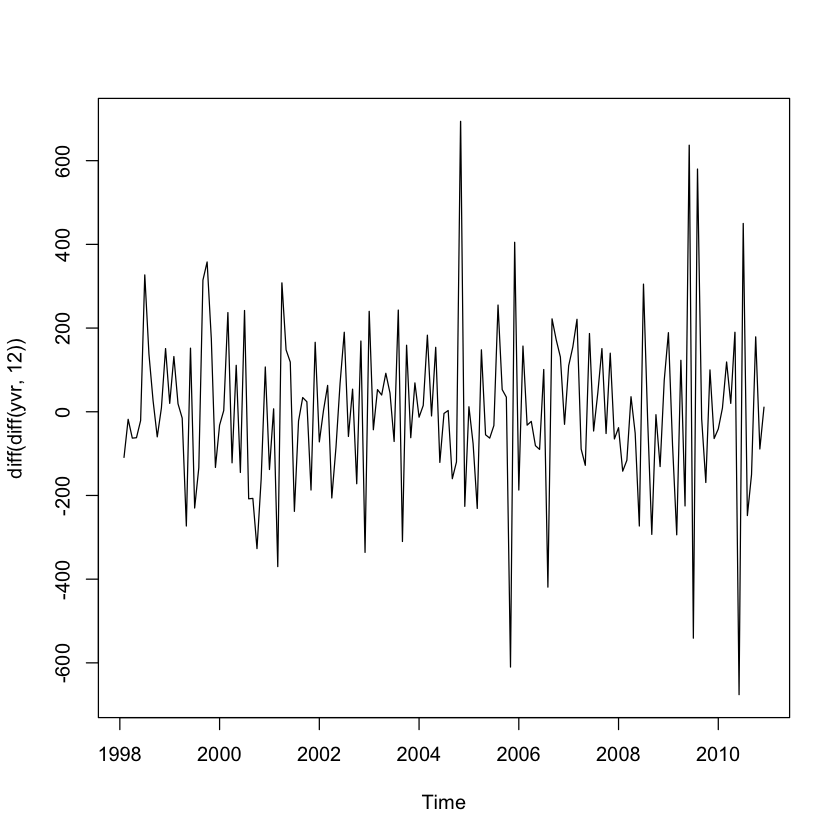

In [53]:
plot(diff(diff(yvr, 12)))


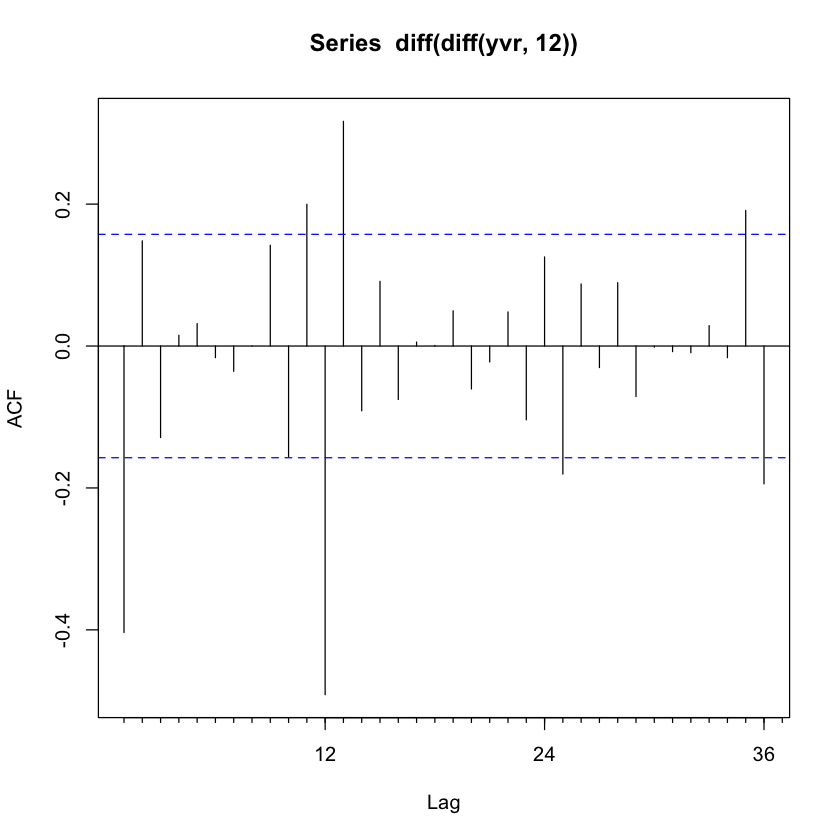

In [54]:
Acf(diff(diff(yvr, 12)), lag.max = 36)

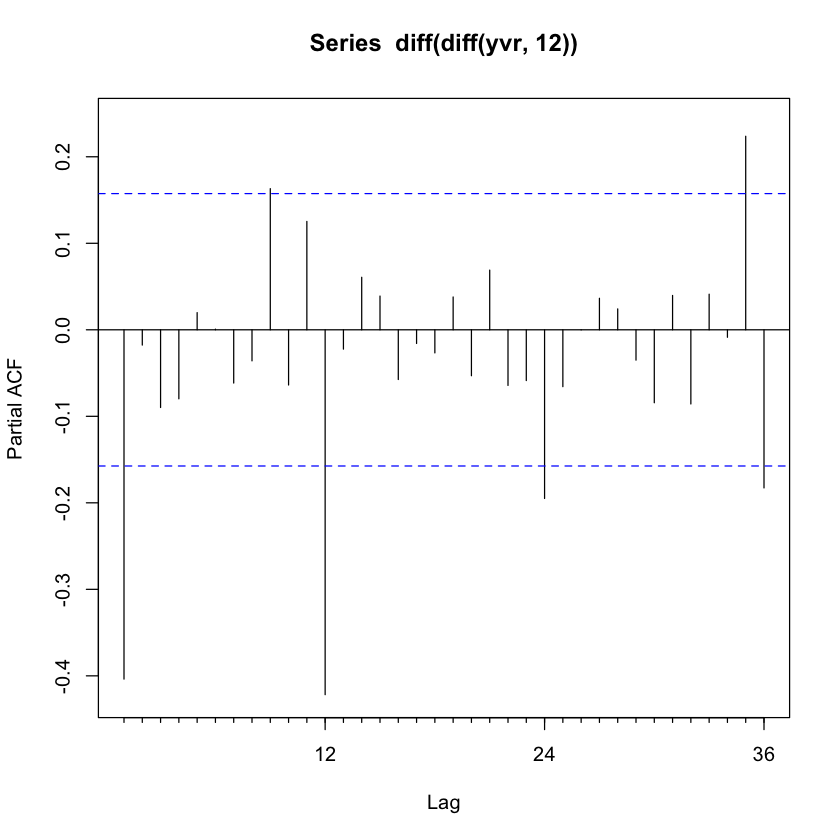

In [55]:
Pacf(diff(diff(yvr, 12)), lag.max = 36)

In [56]:
lambda = BoxCox.lambda(yvr.train); lambda


[1] 1.372237

In [57]:
yvr.arima = Arima(yvr.train, order = c(2, 1, 0), seasonal = c(0, 1, 1))
yvr.arima1 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 1))
yvr.arima2 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 2))
yvr.autoarima = auto.arima(yvr.train, stepwise = FALSE, approximation = FALSE)
yvr.arima3 = Arima(yvr.train, order = c(3, 1, 0), seasonal = c(0, 1, 1), lambda = lambda)


In [58]:
arimaforecast = forecast(yvr.arima, h = 36)
arimaforecast1 = forecast(yvr.arima1, h = 36)
arimaforecast2 = forecast(yvr.arima2, h = 36)
arimaforecast3 = forecast(yvr.autoarima, h = 36)
arimaforecast4 = forecast(yvr.arima3, h = 36)


In [59]:
method = c('(2, 1, 0), (0, 1, 1)', '(3, 1, 0), (0, 1, 1)','(3, 1, 0), (0, 1, 2)', 'Auto Arima', '(3, 1, 0), (0, 1, 1) with Box-Cox Transformation')
cbind(method, rbind(round(accuracy(arimaforecast, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
        round(accuracy(arimaforecast1, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1), 
        round(accuracy(arimaforecast2, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1),
        round(accuracy(arimaforecast3, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1),
        round(accuracy(arimaforecast4, yvr.test)['Test set', c('RMSE', 'MAE', 'MAPE', 'MASE')], 1)))


method,RMSE,MAE,MAPE,MASE
"(2, 1, 0), (0, 1, 1)",160.6,126.4,1.6,0.5
"(3, 1, 0), (0, 1, 1)",160.6,127.1,1.7,0.5
"(3, 1, 0), (0, 1, 2)",168.8,128.2,1.7,0.5
Auto Arima,532,459.6,6,1.7
"(3, 1, 0), (0, 1, 1) with Box-Cox Transformation",164.7,123.9,1.6,0.5


In [60]:
summary(yvr.arima1)

Series: yvr.train 
ARIMA(3,1,0)(0,1,1)[12] 

Coefficients:
          ar1      ar2      ar3     sma1
      -0.2023  -0.0281  -0.0232  -0.8954
s.e.   0.0923   0.0942   0.0917   0.1859

sigma^2 = 19096:  log likelihood = -762.48
AIC=1534.96   AICc=1535.49   BIC=1548.85

Training set error measures:
                  ME     RMSE      MAE       MPE     MAPE      MASE
Training set 9.87671 128.9842 94.15046 0.1308541 1.497663 0.3553071
                     ACF1
Training set -0.007119146

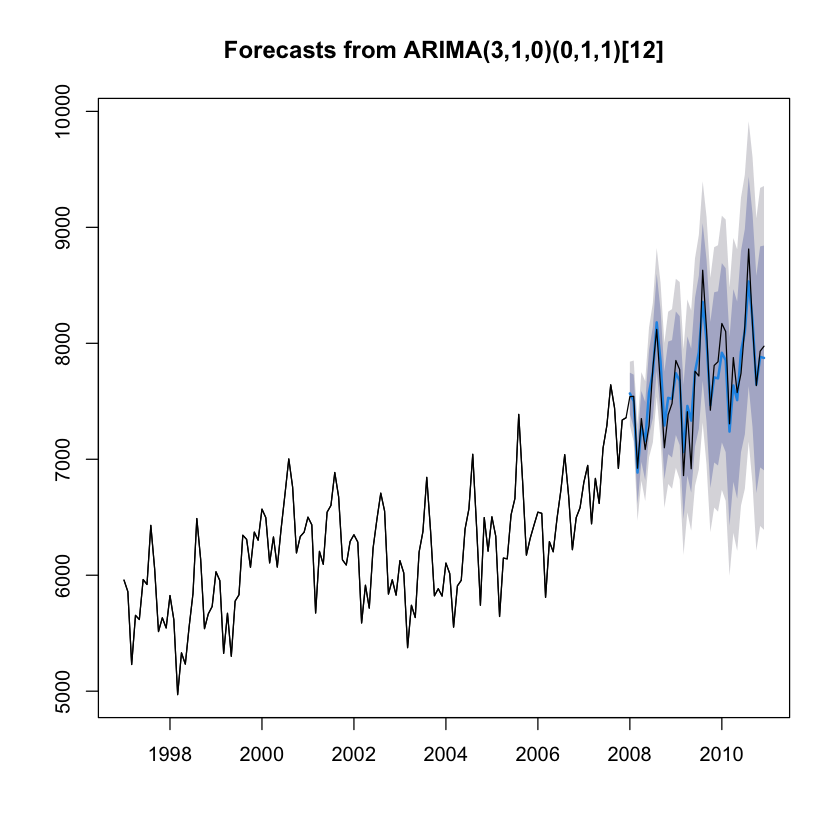

In [61]:
plot(forecast(yvr.arima1, h = 36))
lines(yvr)